In [1]:
!pip install tensorflow-quantum

     |████████████████████████████████| 5.9MB 9.0MB/s 
     |████████████████████████████████| 5.6MB 30.8MB/s 
     |████████████████████████████████| 1.6MB 53.7MB/s 
  Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:
      Successfully uninstalled sympy-1.7.1


In [2]:
!pip install -U tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 460kB 51.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [3]:
#Importing tensorflow
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

#Importing some tensorflow quantum stuff
import cirq
import sympy

#For data manipulation
import numpy as np

import collections

#to plot stuff
import matplotlib.pyplot as plt

In [4]:
#Get our MNIST Data and split it up (actualy this looks pretty simple compared to pytorch :thinking:)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Models work better when you turn the range from 0 to 1.. Since the max is 255, we just divide by 225 to get a range of 0 to 1
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
#Very interesting... It's litterally a giant array
x_train.shape, x_train[0].shape, x_train[0][0][0]

((60000, 28, 28, 1), (28, 28, 1), array([0.]))

In [6]:
#We take our data (which is litterally just floats in a giant array, and turn it into Tensors/tensorflow floats)
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

In [7]:
#Yup, worked!
x_train.shape, x_train[0].shape, x_train[0][0][0]

(TensorShape([60000, 28, 28, 1]),
 TensorShape([28, 28, 1]),
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)

In [8]:
#When we pass our thing through our quantum network, we're going to downsclae it to a 10x10 image.. (speed reasons)... But I'll try out a bigger image later
#Also very interesting how TF does it....
x_train = tf.image.resize(x_train[:], (10,10)).numpy()
x_test = tf.image.resize(x_test[:], (10,10)).numpy()

In [9]:
#Yup, worked!
x_train.shape, x_train[0].shape, x_train[0][0][0]

((60000, 10, 10, 1), (10, 10, 1), array([0.], dtype=float32))

In [10]:
# y_train, y_train.shape

In [11]:
# #reformating the label data
# y_train = y_train[:]
# y_test = y_test[:]

In [12]:
# y_train, y_train.shape

7


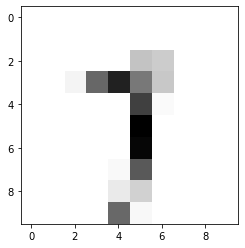

In [13]:
#Alright just present it to make sure it's structured correctly
print(y_train[42])

fig = plt.figure()
plt.imshow(x_train[42, :, :, 0], cmap = 'gray_r')

In [14]:
#Lol that's an ugly 7. For curiosity's sake, I'm going to bump it up to say... 15x15

7


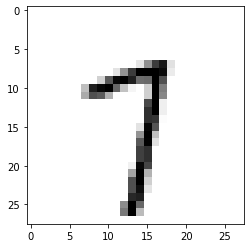

In [15]:
(x_train_new, y_train_new), (x_test_new, y_test_new) = tf.keras.datasets.mnist.load_data()
x_train_new, x_test_new = x_train_new[..., np.newaxis]/255.0, x_test_new[..., np.newaxis]/255.0
x_train_new = tf.cast(x_train_new, tf.float32)
x_test_new = tf.cast(x_test_new, tf.float32)
print(y_train_new[42])

fig = plt.figure()
plt.imshow(x_train_new[42, :, :, 0], cmap = 'gray_r')

In [16]:
#yeah this is much much clearer

In [17]:
device_name = tf.test.gpu_device_name()

In [18]:
#Defining the whole thing!!!
class QConv(tf.keras.layers.Layer):
  #initializaiton of the QCNN layer
  def __init__(self, filter_size, depth, activation = None, name = None, kernel_regularizer=None, **kwangs):
    #Standard notation thingy
    super(QConv, self).__init__(name=name, **kwangs)

    #Defining of the varaibles
    self.filter_size = filter_size
    self.depth = depth
    self.learning_params = []
    self.QCNN_layer_gen()
    self.activation = tf.keras.layers.Activation(activation)
    self.kernel_regularizer = kernel_regularizer
  
  #Initialize parameters for the quantum gates
  def _get_new_param(self):
    #Literally just generates a string "p0"... Instead of 0 it's just a number that
    new_param = sympy.symbols('p'+str(len(self.learning_params)))
    #Increase the size of the list (thus the numbers keep increasing (so there's no duplicates))
    self.learning_params.append(new_param)
    return new_param
  
  #This just defines 2 parameterized qubit gates and places them
  def _QConv(self, step, target, qubits):
    #First defining a Z and an X gate. First part = the rotation value (where we place our parameter), second part = where we place our gates
    yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
    yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
  
  def QCNN_layer_gen(self):
    #Pixels = the area which the filter will cover
    pixels = self.filter_size**2

    #So we're going to take our kernal and map it to qubits
    cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)

    #How you define the start of a quantum circuit
    input_circuit = cirq.Circuit()

    #There's another set of parameterized gates here. And we've got to define it's parameters
    input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]

    #Now we apply those initial RX gates at the beginning for each qubit
    for i, qubit in enumerate(cirq_qubits):
      input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))
    
    #We're going to start antoher part, this time it's the kernal part
    QCNN_circuit = cirq.Circuit()

    #Basically something to help with the architechture of the kernal part (to help with the placement of the X and Z gates)
    step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
    
    #This is the appending of said X and Z gates
    for step in step_size:
      for target in range(0, pixels, 2*step):
        QCNN_circuit.append(self._QConv(step,target,cirq_qubits))
    
    #now take the 2 parts of the quantum circuit to merge them all together
    full_circuit = cirq.Circuit()
    full_circuit.append(input_circuit)
    full_circuit.append(QCNN_circuit)

    #save it to use it later
    self.circuit = full_circuit

    #Save the parameters to use later
    self.params = input_params + self.learning_params

    #Save the operators (for the output) for later use
    self.op = cirq.Z(cirq_qubits[0])
  
  #Intializes everything... It creates the layer (with weights and stuff)
  def build(self, input_shape):
    #What's the input (image) width? Height? Number of channels?
    self.width = input_shape[1]
    self.height = input_shape[2]
    self.channel = input_shape[3]

    # The number of times which the kernal will pass on the image
    self.num_x = self.width - self.filter_size + 1
    self.num_y = self.height - self.filter_size + 1

    #Initializing the kernal! name, (how many (if there are 8, then it'll be a rectangular prism, but ostensibly 8 different kernals), channels, number of parameters each)
    #Then we initialzie the parameters, plus slap on a regularator if we wanted to
    self.kernel = self.add_weight(name = 'kernal',
                                 shape = [self.depth, self.channel, len(self.learning_params)],
                                 initializer = tf.keras.initializers.glorot_normal(),
                                 regularizer = self.kernel_regularizer)
    
    #We take our thing and convert it to a (quantum?) tensor
    self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
  
  #Where the computation happens
  def call(self, inputs):
    #This is generating a giant stack of all the segements of the inputs which we're going to pass over the kernal
    #Also: It's just adding the slice to the whole stack each time. (It works like. Which cord on the map, then take a bit out of that with the size) 
    stack_set = None
    for i in range(self.num_x):
      for j in range(self.num_y):
        slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
        slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
        if stack_set == None:
          stack_set = slice_part
        else:
          stack_set = tf.concat([stack_set, slice_part], 1)
    #Then we just reformat it
    stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
    stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])

    #Kind of reformats (except with some duplication) the (quantum?) tensor into a usable form
    circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
    circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
    tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
    
    #Gonna take our inputs (now in the form of the stack) and pass them through our kernals
    outputs = []
    for i in range(self.depth):
      #Now we call the kernals we defined in build
      controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
      #Actually passing into the QCNN layer
      outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
    #reformating
    output_tensor = tf.stack(outputs, axis=3)
    output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
    
    #Take our output, shove it through the activation, and then return it
    return self.activation(output_tensor)
  
  def single_depth_QCNN(self, input_data, controller, circuit_inputs):
    #Shove it on GPU
    with tf.device('/device:GPU:0'):
      #Reformat the input data
      input_data = tf.concat([input_data, controller],1)
      #Then taking our input and shoving it through the QCNN (along with it's paramters)
      QCNN_output = tfq.layers.Expectation()(circuit_inputs,
                                            symbol_names = self.params,
                                            symbol_values = input_data,
                                            operators = self.op)
      #Reformat x 2
      QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
      return tf.math.reduce_sum(QCNN_output, 3)

In [19]:
#Defining the varaibles to intitalize the QCNN
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

In [20]:
#Initializing the model
qcnn_model = models.Sequential()
#The QCNN!!!!!
qcnn_model.add(QConv(filter_size=2, depth=4, activation='relu', 
                     name='qconv1', input_shape=(width, height, 1)))
qcnn_model.add(QConv(filter_size=2, depth=8, activation='relu', 
                     name='qconv2', input_shape=(width-1, height-1, 1)))
#So we can pase it to linear layers
qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(32, activation='relu'))
#Important to have a softmax here... So all the probabilities add up to 100%
qcnn_model.add(layers.Dense(10, activation='softmax'))

In [21]:
qcnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
qconv1 (QConv)               (None, 9, 9, 4)           24        
_________________________________________________________________
qconv2 (QConv)               (None, 8, 8, 8)           192       
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 16,962
Trainable params: 16,962
Non-trainable params: 0
_________________________________________________________________


In [22]:
# #This is to just to draw it out
# SVGCircuit(QConv(filter_size=2, depth=8, activation='relu').circuit)

In [23]:
#Getting ready to train (optimizer, loss, metrics)
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
#Train it!!! (Taking out validation accuracy during training because takes too long)
qcnn_history = qcnn_model.fit(x_train, y_train, steps_per_epoch=500,
                        epochs=5, batch_size=5)

Epoch 1/5
500/500 [==============================] - 575s 1s/step - loss: 1.1379 - accuracy: 0.6500
Epoch 2/5
500/500 [==============================] - 574s 1s/step - loss: 0.7065 - accuracy: 0.7752
Epoch 3/5
500/500 [==============================] - 577s 1s/step - loss: 0.6211 - accuracy: 0.8024
Epoch 4/5
500/500 [==============================] - 579s 1s/step - loss: 0.6060 - accuracy: 0.8012
Epoch 5/5
500/500 [==============================] - 579s 1s/step - loss: 0.5874 - accuracy: 0.8152


In [29]:
#Outputing validation accuracy:
test_loss, test_acc = qcnn_model.evaluate(x_test, y_test, verbose=2)

313/313 - 1141s - loss: 0.5303 - accuracy: 0.8335


In [ ]:
#Plot loss curves:
fig = plt.figure()
plt.plot(np.arange(len(qcnn_history.history['loss'])) + 1, qcnn_history.history['loss'])

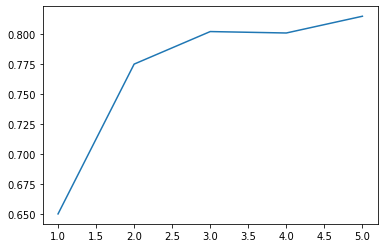

In [30]:
#Plot acc  curves:
fig = plt.figure()
plt.plot(np.arange(len(qcnn_history.history['accuracy'])) + 1, qcnn_history.history['accuracy'])

In [28]:
#Okay I played around with the size and it seems like the bigger your input size is, the longer it takes (like 1 eoch was going to talk 1 hour)... Accuracy was still going up so it was working
#I'm just going to attach an additional quanvolutional layer to it and see what it does hahaha
#Seems like more filters the worst off it becomes too... 